In [2]:
pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DAT SET 3",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3381 files belonging to 30 classes.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
class_names = dataset.class_names
class_names

['Geranium_ Pelargonium spp. (Genus)',
 'Giant Pigweed_Amaranthus titan',
 'Ginger-Zingiber officinale',
 'Globe Amarnath-Gomphrena globosa',
 'Gongura_Hibiscus sabdariffa',
 'Green Chireta_Andrographis paniculata',
 'Henna-Lausonia inermis',
 'Hibiscus-Hibiscus rosa sinensis',
 'Holy Basil_ Ocimum sanctum',
 'Honge-Milletia',
 'Indian CopperLeaf_ Acalypha indica',
 'Indian Jujube_Ziziphus mauritiana',
 'Indian Sarsaparilla_Hemidesmus indicus',
 'Indian Stinging Nettle_Urtica dioica subsp. gracilis',
 'Indian Thornapple_Datura metel',
 'Indian pennywort_Centella asiatica',
 'Indian wormwood_Artemisia indica',
 'Insulin',
 'Ivy Gourd_Coccinia grandis',
 'Jackfruit-Artocarpus heterophyllus',
 'Jamaica Cherry-Gasagase_ Muntingia calabura',
 'Jamun_Syzygium cumini',
 'Jasmine-Jasmium',
 'Kambajala',
 'Karanda_Carissa carandas',
 'Kasambruga',
 'heart-leaved moonseed_ Tinospora cordifolia',
 'indian Beech_Pongamia pinnata',
 'kamakasturi',
 'kepala']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[26  7  6 13 13 23  9 16  6  9 22 11  2 19 24  9 28 10  9 27  7 26  9 10
 13 22 10 16 22 17 19  7]


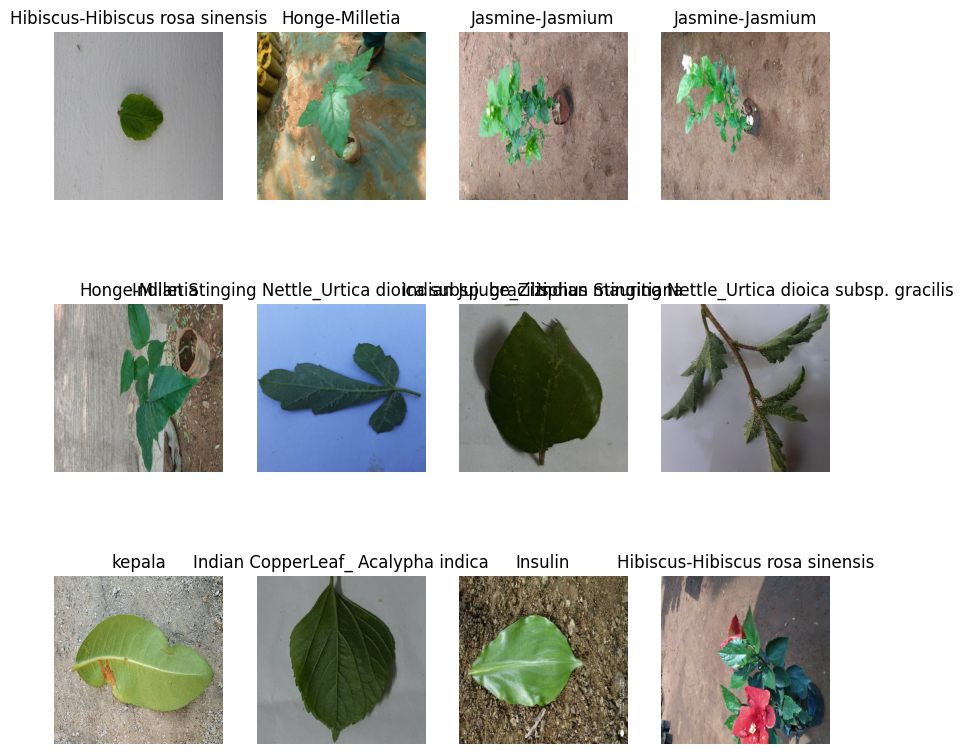

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

106

In [9]:
train_size = 0.8
len(dataset)*train_size

84.80000000000001

In [10]:
train_ds = dataset.take(99)
len(train_ds)

99

In [11]:
test_ds = dataset.skip(99)
len(test_ds)

7

In [12]:
val_size=0.1
len(dataset)*val_size

10.600000000000001

In [13]:
val_ds = test_ds.take(12)
len(val_ds)

7

In [14]:
test_ds = test_ds.skip(12)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

84

In [18]:
len(val_ds)

10

In [19]:
len(test_ds)

12

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 169

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)

84/84 [==============================] - 25s 289ms/step - loss: 0.3275 - accuracy: 0.8905 - val_loss: 0.3694 - val_accuracy: 0.8906


In [54]:
scores=model.evaluate(test_ds)

12/12 [==============================] - 0s 30ms/step - loss: 0.3755 - accuracy: 0.8672


In [33]:
scores

[0.5016804933547974, 0.8255208134651184]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 84}

first image to predict
actual label: Ginger-Zingiber officinale
1/1 [==============================] - 0s 33ms/step
predicted label: Ginger-Zingiber officinale


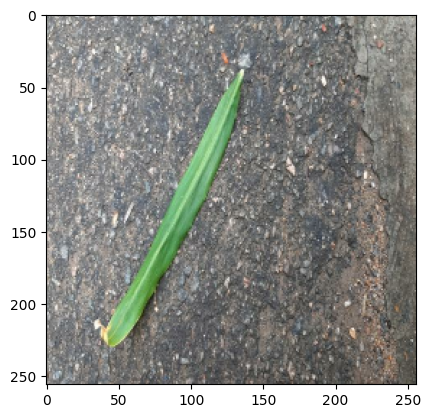

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'predict' is not defined

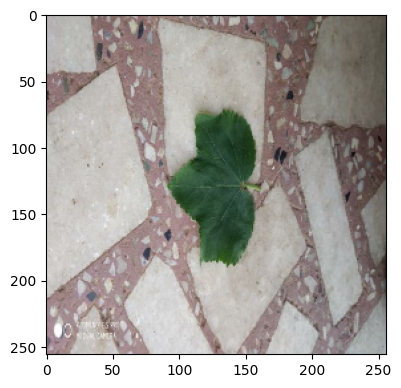

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


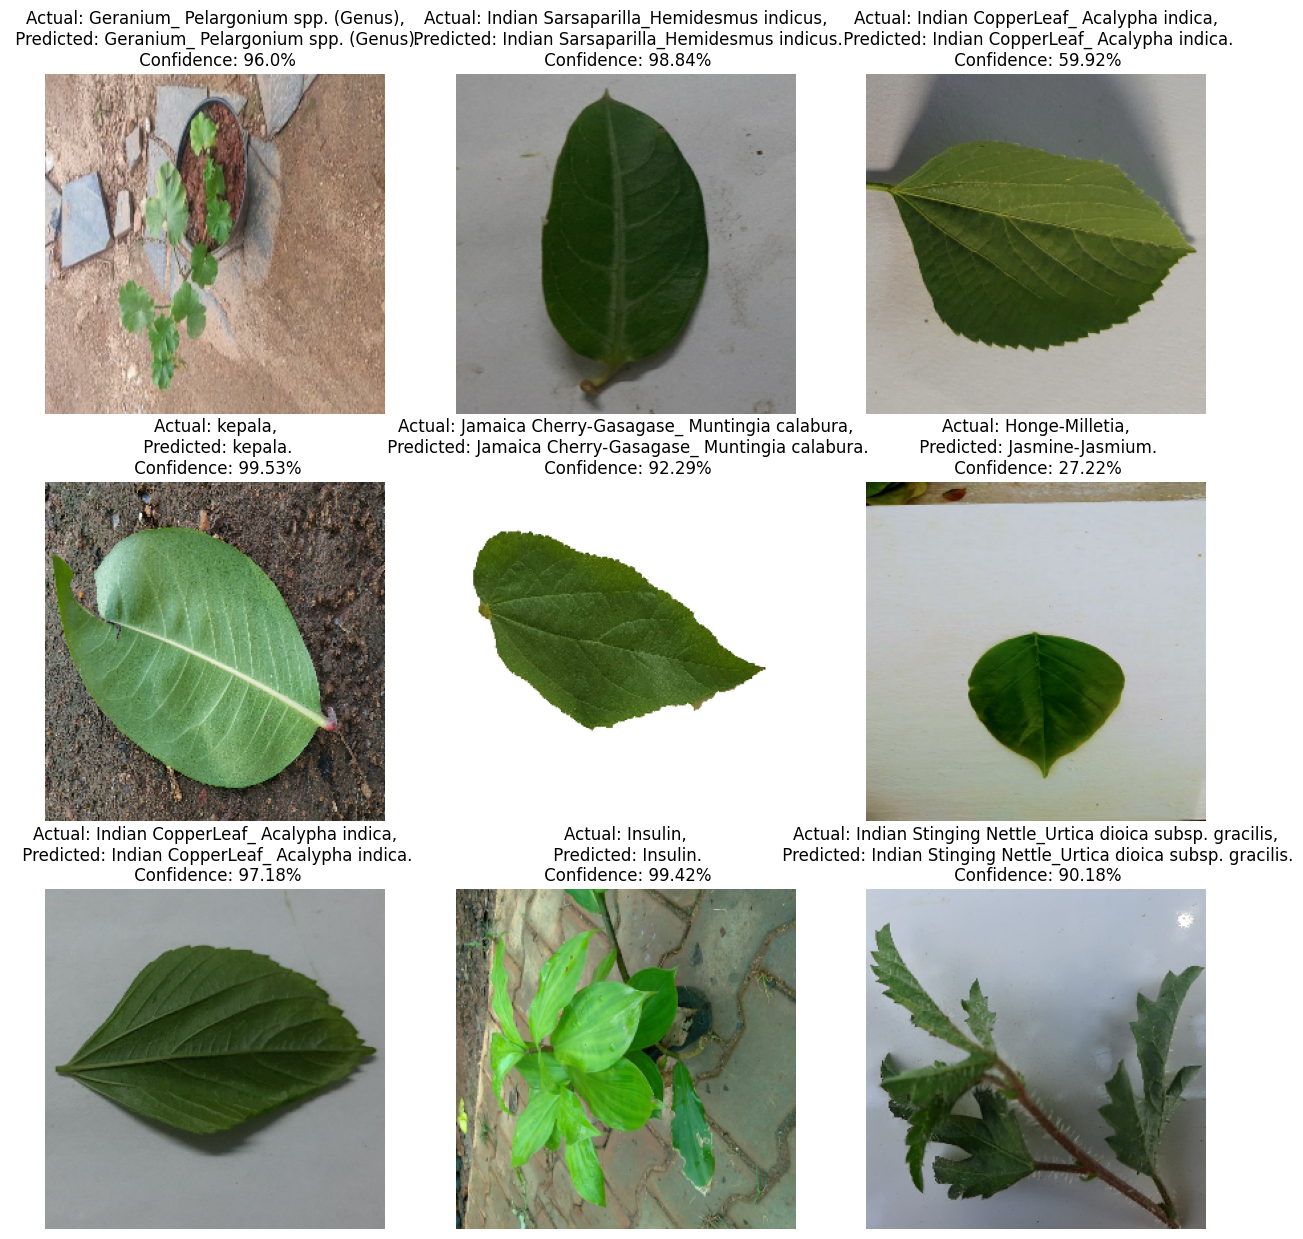

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [52]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/model3')